In [1]:
#| hide
!pip install -Uqq nixtla cryptocmd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.7 MB/s eta 0:00:00


# Bitcoin price prediction

> Learn how to use TimeGPT for financial time series forecasting

## Introduction

Forecasting time series is a ubiquitous task in finance, supporting decisions in trading, risk management, and strategic planning. Despite its prevalence, predicting the future prices of financial assets remains a formidable challenge, mainly due to the inherent volatility of financial markets.

For those who believe in the feasibility of forecasting these assets, or for professionals whose roles require such predictions, TimeGPT is a powerful tool that simplifies the forecasting process.

In this tutorial, we will demonstrate how to use TimeGPT for financial time series forecasting, focusing on Bitcoin price prediction. We will also showcase how to use TimeGPT for uncertainty quantification, which is essential for risk management and decision-making.

**Outline:**

1. [Load Ethereum Price Data](#load-bitcoin-price-data)

2. [Get Started with TimeGPT](#get-started-with-timegpt)

3. [Visualize the Data](#visualize-the-data)

4. [Forecast with TimeGPT](#forecast-with-timegpt)

5. [Extend Bitcon Price Analysis with TimeGPT](#extend-bitcoin-price-analysis-with-timegpt)

6. [Understand the Model's Limitations](#understand-the-models-limitations)

7. [References and Additional Material](#references-and-additional-material)

## 1. Load Ethereum Price Data

In [4]:
!pip install requests pandas

In [26]:
import requests
import pandas as pd
from datetime import datetime

# Define the API endpoint and parameters
api_url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart'
params = {
    'vs_currency': 'usd',
    'days': 'max',  # Fetches data for the maximum available period
    'interval': 'daily'
}

# Make the API request
response = requests.get(api_url, params=params)
data = response.json()

# Convert the data into a pandas DataFrame
prices = data['prices']
df = pd.DataFrame(prices, columns=['timestamp', 'price'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Rename columns for clarity
df.rename(columns={'timestamp': 'ds', 'price': 'y'}, inplace=True)

# Display the first few rows of the DataFrame
print(df.head())

          ds         y
0 2015-08-07  2.831620
1 2015-08-08  1.330750
2 2015-08-10  0.687586
3 2015-08-11  1.067379
4 2015-08-12  1.256613


In [28]:
# Calculate the time difference between consecutive timestamps
df['time_diff'] = df['ds'].diff()

# Check for inconsistencies
print(df['time_diff'].value_counts())

time_diff
1 days 00:00:00           3403
2 days 00:00:00              1
1 days 00:05:11.070000       1
0 days 23:54:48.930000       1
1 days 00:05:23.681000       1
0 days 23:54:36.319000       1
0 days 00:40:59              1
Name: count, dtype: int64


In [30]:
# Step 1: Set 'ds' as the index
df = df.set_index('ds')

# Step 2: Reindex with a regular daily frequency ('D')
df = df.asfreq('D')

# Step 3: Interpolate missing values for 'y' (caused by reindexing)
df['y'] = df['y'].interpolate()

# Step 4: Reset the index
df = df.reset_index()

# Verify the changes
print(df.head())

          ds         y time_diff
0 2015-08-07  2.831620       NaT
1 2015-08-08  1.330750    1 days
2 2015-08-09  1.009168       NaT
3 2015-08-10  0.687586    2 days
4 2015-08-11  1.067379    1 days


In [31]:
# Verify frequency of the 'ds' column
df['time_diff'] = df['ds'].diff()
print(df['time_diff'].value_counts())  # Should show only "1 days" now

time_diff
1 days    3409
Name: count, dtype: int64


## 2. Get Started with TimeGPT

To get started with `TimeGPT`, you need to instantiate the `NixtlaClient` class. For this, you will need a Nixtla API key.

In [6]:
from nixtla import NixtlaClient

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-PseOV5xcLQgFjLnmaFe2YibaW13DDtTJExJWjDBhhtQsyXt3BvjfhsMhxbLbbMgl79gmK9TE9BoWhSWD'
)

## 3. Visualize the Data

Before attempting any forecasting, it is good practice to visualize the data we want to predict. The `NixtlaClient` class includes a `plot` method for this purpose.

The `plot` method has an `engine` argument that allows you to choose between different plotting libraries. Default is `matplotlib`, but you can also use `plotly` for interactive plots.

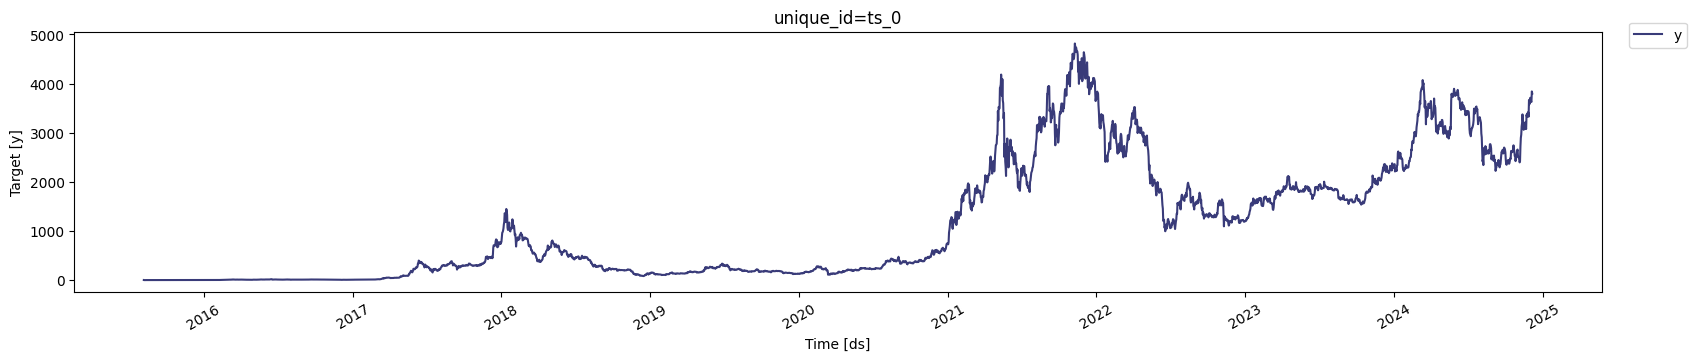

In [32]:
nixtla_client.plot(df)

If you haven't renamed the column names of your DataFrame to `ds` and `y`, you will need to specify the `time_col` and `target_col` arguments of the `plot`method:

``` python
nixtla_client.plot(df, time_col='name of your time column', target_col='name of your target column')
```

This is necessary not only for the `plot` method but for all methods from the `NixtlaClient` class.

## 4. Forecast with TimeGPT

Now we are ready to generate predictions with TimeGPT. To do this, we will use the `forecast` method from the `NixtlaClient` class.

The `forecast` method requires the following arguments:

- `df`: The DataFrame containing the time series data

- `h`: (int) The forecast horizon. In this case, we will forecast the next 7 days.

- `level`: (list) The confidence level for the prediction intervals. Given the inherent volatility of Bitcoin, we will use multiple confidence levels.

In [35]:
level = [50,80,90] # confidence levels

fcst = nixtla_client.forecast(df, h=70, level=level)
fcst.head()

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['time_diff'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2024-12-07,3806.6080,3898.6604,3984.9272,4041.0596,3714.5554,3628.2886,3572.1562
1,2024-12-08,3830.0693,3958.3848,4004.5205,4058.7817,3701.7540,3655.6182,3601.3570
2,2024-12-09,3821.6555,3924.5042,3999.6802,4117.0317,3718.8070,3643.6309,3526.2793
3,2024-12-10,3798.0886,3899.5340,3995.5650,4151.4653,3696.6433,3600.6123,3444.7120
4,2024-12-11,3781.3900,3874.8901,3976.4724,4115.8784,3687.8896,3586.3074,3446.9014


We can pass the forecasts we just generated to the `plot` method to visualize the predictions with the historical data.  

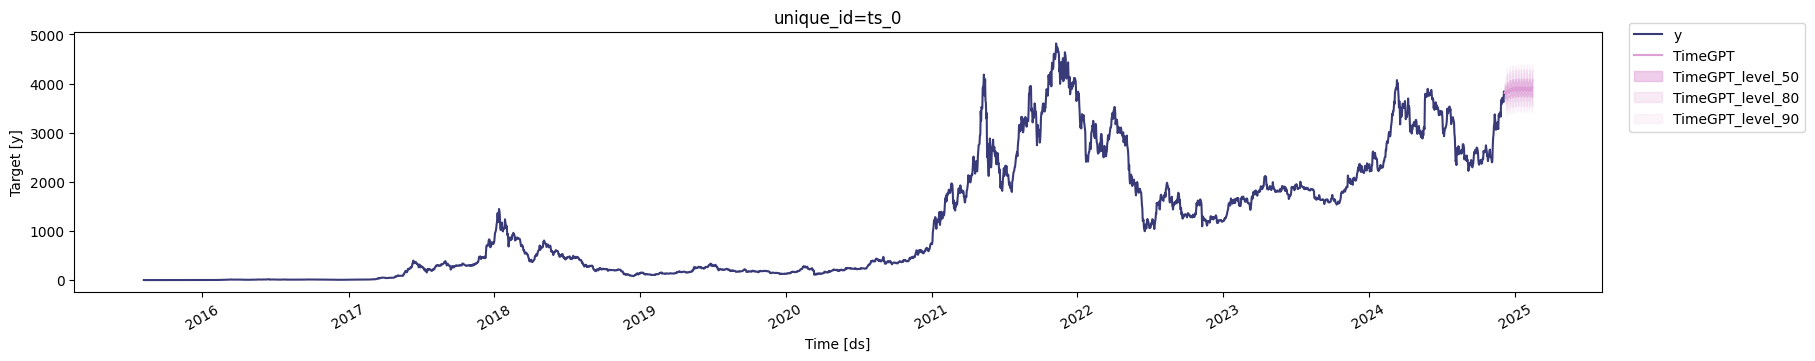

In [36]:
nixtla_client.plot(df, fcst, level=level)

To get a closer look at the predictions, we can zoom in on the plot or specify the maximum number of in-sample observations to be plotted using the `max_insample_length` argument. Note that setting `max_insample_length=60`, for instance, will display the last 60 historical values along with the complete forecast.  

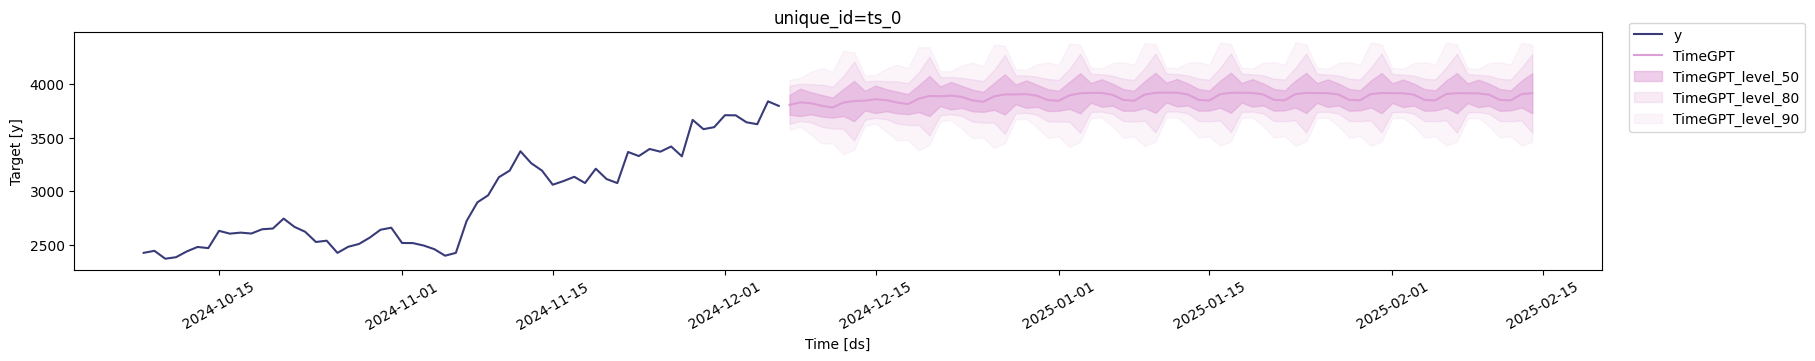

In [37]:
nixtla_client.plot(df, fcst, level=level, max_insample_length=60)

Additionally, if you set the `add_history` argument of the `forecast` method to `True`, `TimeGPT` will generate predictions for the historical observations too. This can be useful for assessing the model's performance on the training data.

In [38]:
forecast = nixtla_client.forecast(df, h=7, level=level, add_history=True)
forecast.head()

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['time_diff'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2015-09-05,1.307202,97.096924,183.31065,234.90611,-94.48252,-180.69626,-232.29170
1,2015-09-06,1.276352,97.066070,183.27980,234.87526,-94.51337,-180.72711,-232.32256
2,2015-09-07,1.223779,97.013500,183.22723,234.82270,-94.56594,-180.77968,-232.37512
3,2015-09-08,1.224134,97.013855,183.22758,234.82304,-94.56558,-180.77933,-232.37477
4,2015-09-09,1.257205,97.046930,183.26067,234.85611,-94.53252,-180.74625,-232.34170


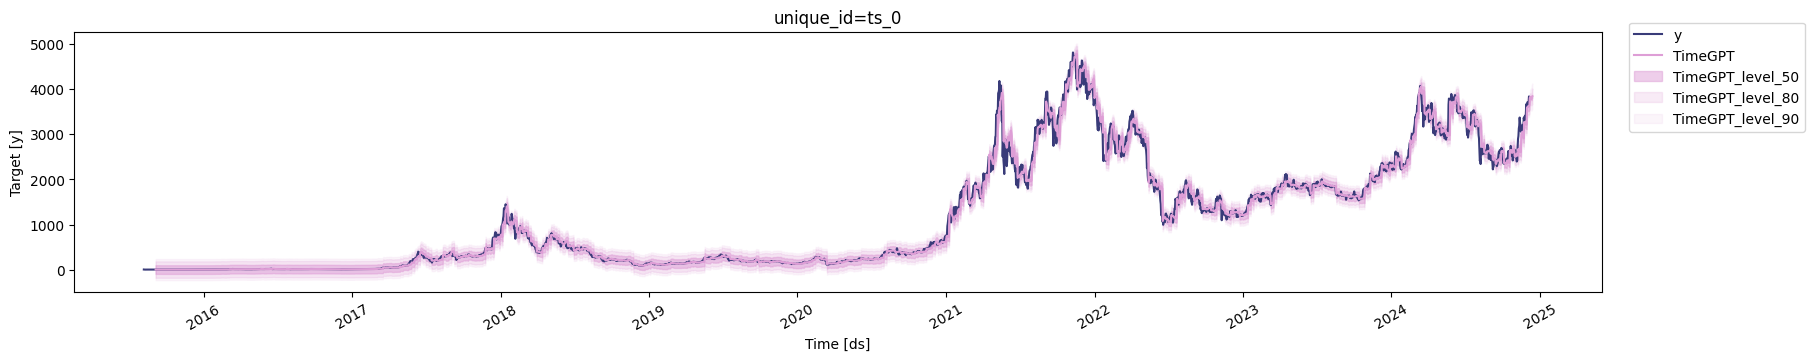

In [39]:
nixtla_client.plot(df, forecast, level=level)

## 5. Extend Bitcoin Price Analysis with TimeGPT

### Anomaly Detection

Given the volatility of the price of Bitcoin, it can be useful to try to identify anomalies in the data. `TimeGPT` can be used for this by calling the `detect_anomalies` method from the `NixtlaClient` class. This method evaluates each observation against its context within the series, using statistical measures to determine its likelihood of being an anomaly. By default, it identifies anomalies based on a 99 percent prediction interval. To change this, you can specify the `level` argument.

In [42]:
# Check for missing values in the dataset
print(df.isnull().sum())

# Display rows with missing values
print(df[df.isnull().any(axis=1)])

ds           0
y            0
time_diff    1
dtype: int64
          ds        y time_diff
0 2015-08-07  2.83162       NaT


In [43]:
# Drop the 'time_diff' column
df = df.drop(columns=['time_diff'])

# Verify the DataFrame after dropping the column
print(df.head())

          ds         y
0 2015-08-07  2.831620
1 2015-08-08  1.330750
2 2015-08-09  1.009168
3 2015-08-10  0.687586
4 2015-08-11  1.067379


In [44]:
anomalies_df = nixtla_client.detect_anomalies(df)

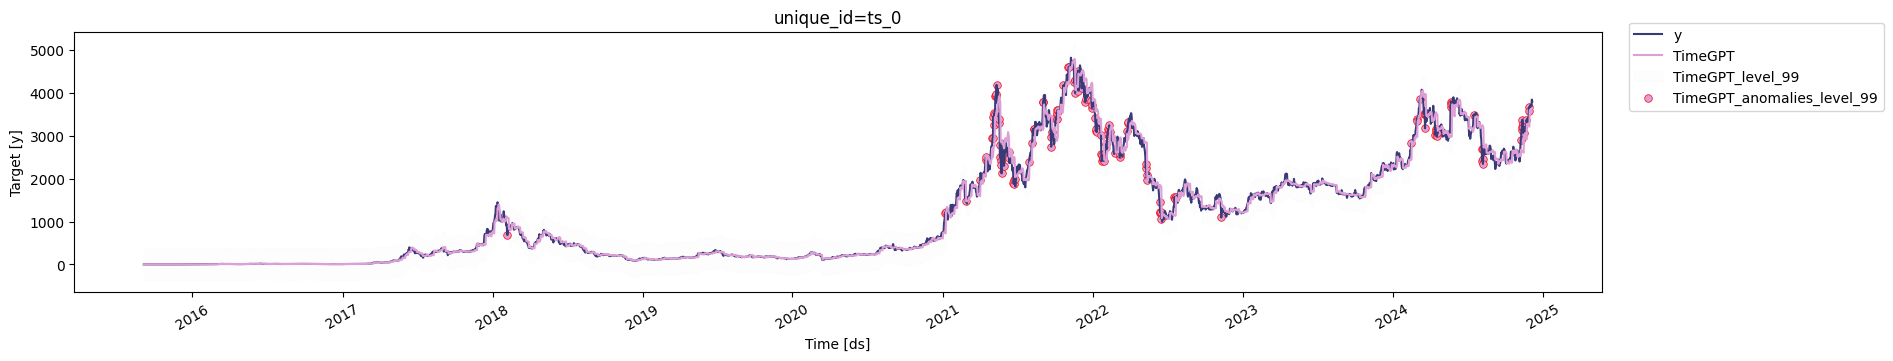

In [45]:
nixtla_client.plot(df, anomalies_df, plot_anomalies=True)

To learn more about how to detect anomalies with `TimeGPT`, take a look at our [Anomaly Detection](https://docs.nixtla.io/docs/capabilities-anomaly-detection-anomaly_detection) tutorial.   

### Add Exogenous Variables

If you have additional information that you believe could help improve the forecast, consider including it as an exogenous variable. For instance, you might add data such as the price of other cryptocurrencies, proprietary information, stock market indices, or the number of transactions in the Bitcoin network.

`TimeGPT` supports the incorporation of exogenous variables in the `forecast` method. However, keep in mind that you'll need to know the future values of these variables.

To learn how to incorporate exogenous variables to `TimeGPT`, refer to the [Exogenous Variables](https://docs.nixtla.io/docs/tutorials-exogenous_variables) tutorial.

## 6. Understand the Model's Limitations

As stated in the introduction, predicting the future prices of financial assets is a challenging task, especially for assets like Ethereum. The predictions in this tutorial may appear accurate, mainly because they align with recent historical data and the model updates with new values at short intervals, avoiding significant deviations. However, the true challenge lies in forecasting Bitcoin's price for the upcoming days, not just its historical performance. For those who need or want to try to forecast these assets, `TimeGPT` can be an option that simplifies the forecasting process. With just a couple of lines of code, `TimeGPT` can help you:

- Produce point forecasts
- Quantify the uncertainty of your predictions
- Produce in-sample forecasts
- Detect anomalies
- Incorporate exogenous variables

To learn more about `TimeGPT` capabilities, please refer to the [TimeGPT Documentation](https://docs.nixtla.io/).

## 7. References and Additional Material

**References**

* [Joaquín Amat Rodrigo and Javier Escobar Ortiz (2022), "Bitcoin price prediction with Python, when the past does not repeat itself"](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)

Furthermore, for many financial time series, the best estimate for the price is often a random walk model, meaning that the best forecast for tomorrow's price is today's price. Nixtla's [StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html) library allows you to easily implement this model and variations.